In [1]:
%reset -f
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from tueplots.bundles import probnum2025
plt.rcParams.update(probnum2025())

### 0. Solutions to the TOV-Equations and Source/Matter Terms

In [2]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Note: the value for the central pressure must be sufficiently low as to avoid having to deal with singularities (visible in alpha, psi)

# Specify and load the file
filename    = f'data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Define polytropic constants (using c = G = 1 units for simplicity)
K     = 100    # Polytropic constant
Gamma = 2      # Polytropic exponent

# Polytropic Equation of State (EOS)
def pressure(rho):
    return K * rho**Gamma
    

In [3]:
# Express the source/matter terms
W  = 1                                         # Lorentz factor
v  = np.zeros_like(rho)                        # radial velocity

E  = rho
Sr = rho * (1 + P/rho) * W**2 * v
S  = rho * (1 + P/rho) * W**2 * v**2 + 3 * P


In [4]:
# # Visualization of the source/matter terms
# # Note: Sr is not plotted as it is zero, and would not show up on a log-log scale
# # plt.figure
# plt.plot(R/R[0], E/E[0], label=r"$E/E(0)$")
# plt.plot(R/R[0], S/S[0], label=r"$S/S(0)$")
# plt.plot(R/R[0], alpha/alpha[0], label=r"$\alpha/\alpha(0)$")
# plt.plot(R/R[0], psi/psi[0], label=r"$\psi/\psi(0)$")
# plt.xscale('log')
# # plt.yscale('log')

# plt.title(r"Matter source functions $(\mathcal{M})$")
# plt.xlabel(r"$r/r_{\min}$")
# plt.legend()
# plt.show()


## 1. Application of a perturbation to the density

In [5]:
# Perturbation parameters
center_value  = 0.5        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-3     # Scale factor

# Center Gaussian
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))

# Multiplication of Gaussian
perturbation  = gaussian * R_centered
rho_perturbed = rho + gaussian * R_centered


# # Visualization
# plt.figure(1)
# plt.plot(R, perturbation)
# plt.xscale('log')
# plt.title("Perturbation Profile on the Density")

# plt.figure(2)
# plt.plot(R, rho, label="Unperturbed density");
# plt.plot(R, rho_perturbed, linestyle='-.', label="Perturbed density");
# plt.xlabel('R');
# plt.xscale('log');
# plt.yscale('log');
# plt.title(r"Perturbed Density: $\rho_{perturbed}$");
# plt.legend();


In [6]:
# Apply the density perturbation of the source/matter terms
E_perturbed  = rho_perturbed
Sr_perturbed = rho_perturbed * (1 + P/rho) * W**2 * v
S_perturbed  = rho * (1 + pressure(rho_perturbed)/rho) * W**2 * v**2 + 3 * pressure(rho_perturbed)

# # Figure: Perturbed source/matter terms
# plt.figure()

# plt.subplot(3, 1, 1)
# plt.plot(R, E_perturbed,  label= "E")
# plt.plot(R, S_perturbed,  label= "S")
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('R')

# plt.legend()
# plt.title("Perturbed Source Terms")

# # Figure: Perturbed velocity
# plt.subplot(3, 1, 2)
# plt.plot(R, perturbation, color="red")
# plt.xscale('log')  
# plt.xlabel('R')
# plt.ylabel(r"Perturbation profile on $\rho$")

# # Figure: Alpha and Psi
# plt.subplot(3, 1, 3)
# plt.plot(R, alpha,  label= r"$\alpha$")
# plt.plot(R, psi,  label= r"$\psi$")
# plt.xscale('log')  
# plt.yscale('log')
# plt.xlabel('R')
# plt.legend()

# plt.tight_layout()
# plt.show()


## Solution to the equation in $\delta \psi$

Given the perturbation on the density, the vector equations are trivially zero.

We focus on the the first scalar equation to solve is:

\begin{equation}
\left(\nabla^{2} + S_{1} \psi^{2} + 7 S_{7} \psi^{8} \right) \delta \psi = \delta S_{1} \psi + \delta S_{7} \psi^{7}
\end{equation}

Such that:
\begin{equation}
    k^{2}_{\psi} = -S_{1} \psi^{2} - 7 S_{7} \psi^{8} 
\end{equation}
in which $S_{1} = -2 \pi \rho_{perturbed}$ and $S_7 = 0$.

The right-hand sides are given by:
\begin{equation}
    \delta S_1 = -2 \pi \delta E = - 2 \pi \delta \rho
\end{equation}

\begin{equation}
    \delta S_7 = 0
\end{equation}

In [7]:
# Define the upper integration bound
R_max = np.max(R)

# Definition of S1
S1 = -2 * np.pi * rho_perturbed

# Definition of source term
source_term_1 = -2*np.pi*perturbation*psi

# Relevant functions
k = - S1 * psi**(2)
l = lambda n, x: np.sqrt(2) * np.sin(n * np.pi * x / R_max)
λ = lambda n   : - (n * np.pi / R_max)**2

# Interpolate to integrate
k_interp = interpolate.interp1d(R, k, kind='cubic', fill_value='extrapolate')

# Integration
def integrand(x, n, m):
    # denumerator: negative due to the product of two complex values
    return l(n, x) * k_interp(x) * np.conj(l(m, x)) / (- np.sqrt(-λ(n)) * np.sqrt(-λ(m)))              

# Visulation of the integrand
n, m = 1, 1
# plt.figure(1)
# plt.plot(R, integrand(R, n, m));
# plt.title(f"Integrand for n={n} and m={m}");

In [8]:
# Computation of K tilde
n_max, m_max = 100, 100

def compute_integral(n, m):
    return integrate.quad(integrand, 0, R_max, args=(n + 1, m + 1))[0]

start = time.time()

K_tilde =  (- np.sqrt(-λ(n)) * np.sqrt(-λ(m))) * np.array(Parallel(n_jobs=-1)(delayed(compute_integral)(n, m) for n in range(n_max) for m in range(m_max))).reshape(n_max, m_max)

stop = time.time()

print(f"Elapsed time: {stop - start}")

Elapsed time: 106.46172976493835


In [9]:
# Computation of lambda dirac
lambda_dirac = np.diag([(- np.sqrt(-λ(n)) * np.sqrt(-λ(n))) for n in range(n_max)])


In [10]:
# # Visualization
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # First subplot: abs(lambda_dirac)
# im1 = axes[0].imshow(np.abs(lambda_dirac), cmap="hot")
# axes[0].set_title(r"$\lambda_n \delta_{nm}$")
# fig.colorbar(im1, ax=axes[0], label=r"$\lambda_n \delta_{nm}$")

# # Second subplot: abs(K)
# im2 = axes[1].imshow(K_tilde, cmap="hot")
# axes[1].set_title(r"$\tilde{K}_{nm}$")
# fig.colorbar(im2, ax=axes[1], label="K")

In [11]:
# Reformulate the problem as Cx = d
C = lambda_dirac - K_tilde


In [12]:
# Interpolation of the source term, to integrate
source_term_1_int = interpolate.interp1d(R, R*source_term_1, kind='cubic', fill_value="extrapolate")

def integrand_b(x, n):
    return l(n, x) * source_term_1_int(x)

d = np.zeros(C.shape[0]).squeeze()
for n in range(n_max):
    d[n] = integrate.quad(integrand_b, 0, R[-1], args=n+1)[0]
    

In [13]:
f = np.linalg.solve(C, d)
# plt.plot(f);
# plt.title("Fourier coefficients of the ODE solution")
# plt.xlabel("Coefficient index");

In [14]:
DD = np.linalg.inv(C) @ np.linalg.inv(C.T)
DD.shape


(100, 100)

In [15]:
DD @ np.array([l(n+1,R) for n in range(DD.shape[0])])

array([[ 8.77962699e-01,  8.78050473e-01,  8.78138248e-01, ...,
         7.25230633e-04,  3.62615349e-04,  3.90866107e-15],
       [-4.41739271e-03, -4.41783436e-03, -4.41827601e-03, ...,
        -4.07270790e-06, -2.03635413e-06, -2.19506281e-17],
       [-4.48295538e-04, -4.48340362e-04, -4.48385186e-04, ...,
        -3.70399182e-07, -1.85199608e-07, -1.99626777e-18],
       ...,
       [ 1.99408346e-11,  1.99274126e-11,  1.99139891e-11, ...,
        -1.16966762e-13, -5.84834226e-14, -1.75201783e-24],
       [ 1.78245931e-11,  1.78114365e-11,  1.77982785e-11, ...,
         1.13697241e-13,  5.68486614e-14, -6.42754996e-25],
       [ 1.58291757e-11,  1.58162858e-11,  1.58033946e-11, ...,
        -1.09994678e-13, -5.49973794e-14,  9.59902934e-26]])

In [16]:
dpsi_solution = lambda x: [f[n]*l(n+1, x) for n in range(len(f))][0]

# plt.figure()
# plt.plot(R, dpsi_solution(R)/R);
# plt.title(r"$\delta \psi$");
# plt.xlabel("R")

# Uncertainty computation
sigma_prior = np.identity(C.shape[0])*amplitude**(-1.5)
p = np.linalg.solve(sigma_prior.T @ C.T, np.array([l(n+1,R) for n in range(DD.shape[0])]))
dpsi_var = np.einsum('ij,ij->j', p, p)

# plt.fill_between(R, dpsi_solution(R)/R - np.sqrt(dpsi_var),  dpsi_solution(R)/R + np.sqrt(dpsi_var), alpha=0.17)

In [17]:
# plt.figure()
# plt.plot(R, psi + dpsi_solution(R)/R);
# plt.fill_between(R, psi + dpsi_solution(R)/R - np.sqrt(dpsi_var), psi + dpsi_solution(R)/R + np.sqrt(dpsi_var), alpha=0.17)
# plt.title(r"$\psi$ after perturbation");
# plt.xlabel("R")

## Solution to the equation in $\delta \alpha \psi$

The second scalar equation to solve is:
\begin{equation}
    \left(\nabla^{2} - S_{\alpha\psi} \right) \delta \left( \alpha \psi \right) = \left( \alpha \psi \right) \delta S_{\alpha\psi}
\end{equation}
Such that:
\begin{equation}
    k^{2}_{\alpha \psi} = S_{\alpha \psi}
\end{equation}
in which $S_{\alpha \psi} = 2 \pi (E + 2S) / \psi^2 = 2 \pi (\rho + 6p) / \psi^2$
The right-hand sides are given by:
\begin{equation}
    \delta S_{\alpha \psi} = 2 \pi ((\delta E + 2 \delta S) \psi - 2 (E + 2S) \delta \psi) / \psi^3 
\end{equation}

In [18]:
# Define the upper integration bound
R_max = np.max(R)

S_alpha_psi = 2 * np.pi * (rho_perturbed + 6 * pressure(rho_perturbed)) / psi**2

# Definition of source term
source_term_2 = alpha*psi*2*np.pi*((perturbation + 2 * 3 * pressure(perturbation))*psi - 2*(rho + 2 * 3 * pressure(rho) * dpsi_solution(R))/psi**3)

# Relevant functions
k = 2 * np.pi * (rho_perturbed + 6 * pressure(rho_perturbed)) / psi**2
l = lambda n, x: np.sqrt(2) * np.sin(n * np.pi * x / R_max)
λ = lambda n   : - (n * np.pi / R_max)**2

k_interp = interpolate.interp1d(R, k, kind='cubic', fill_value='extrapolate')
# Integration
def integrand(x, n, m):
    # denumerator: negative due to the product of two complex values
    return l(n, x) * k_interp(x) * np.conj(l(m, x)) / (- np.sqrt(-λ(n)) * np.sqrt(-λ(m)))              

# Visulation of the integrand
n, m = 1, 1
# plt.figure(1)
# plt.plot(R, integrand(R, n, m));
# plt.title(f"Integrand for n={n} and m={m}");


In [19]:
# Computation of K tilde
n_max, m_max = 100, 100

def compute_integral(n, m):
    return integrate.quad(integrand, 0, R_max, args=(n + 1, m + 1))[0]

start = time.time()

K_tilde =  (- np.sqrt(-λ(n)) * np.sqrt(-λ(m))) * np.array(Parallel(n_jobs=-1)(delayed(compute_integral)(n, m) for n in range(n_max) for m in range(m_max))).reshape(n_max, m_max)

stop = time.time()

print(f"Elapsed time: {stop - start}")


Elapsed time: 105.57265782356262


In [20]:
# Computation of lambda dirac
lambda_dirac = np.diag([(- np.sqrt(-λ(n)) * np.sqrt(-λ(n))) for n in range(n_max)])


In [21]:
# # Visualization
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # First subplot: abs(lambda_dirac)
# im1 = axes[0].imshow(np.abs(lambda_dirac), cmap="hot")
# axes[0].set_title(r"$\lambda_n \delta_{nm}$")
# fig.colorbar(im1, ax=axes[0], label=r"$\lambda_n \delta_{nm}$")

# # Second subplot: abs(K)
# im2 = axes[1].imshow(K_tilde, cmap="hot")
# axes[1].set_title(r"$\tilde{K}_{nm}$")
# fig.colorbar(im2, ax=axes[1], label="K")

In [22]:
# Reformulate the problem as Cx = d
C = lambda_dirac - K_tilde


In [23]:
# Interpolation of the source term
source_term_2_int = interpolate.interp1d(R, R*source_term_2, kind='cubic', fill_value="extrapolate")

def integrand_b(x, n):
    return l(n, x) * source_term_2_int(x)

d = np.zeros(C.shape[0]).squeeze()
for n in range(n_max):
    d[n] = integrate.quad(integrand_b, 0, R[-1], args=n+1)[0]
    

In [24]:
g = np.linalg.solve(C, d)
# plt.plot(g)
# plt.title("Fourier coefficients of the ODE solution")
# plt.xlabel("Coefficient index");

In [25]:
d_alpha_psi_solution = lambda x: [g[n]*l(n+1, x) for n in range(len(g))][0]

# Uncertainty computation
sigma_prior = np.identity(C.shape[0])*amplitude**(-0.75)
p = np.linalg.solve(sigma_prior.T @ C.T, np.array([l(n+1,R) for n in range(DD.shape[0])]))
dalpha_psi_var = np.einsum('ij,ij->j', p, p)

# plt.figure()
# plt.plot(R, d_alpha_psi_solution(R)/R)
# plt.title(r"$\delta \alpha \psi$");
# plt.xlabel("R");

# plt.fill_between(R, d_alpha_psi_solution(R)/R - np.sqrt(dalpha_psi_var),  d_alpha_psi_solution(R)/R + np.sqrt(dalpha_psi_var), alpha=0.17)


In [26]:
# plt.plot()
# plt.plot(R, alpha*psi + d_alpha_psi_solution(R)/R)
# plt.fill_between(R, alpha*psi + d_alpha_psi_solution(R)/R - np.sqrt(dalpha_psi_var), alpha*psi + d_alpha_psi_solution(R)/R + np.sqrt(dalpha_psi_var), alpha=0.17)

# plt.title(r"$\alpha \psi$ after perturbation");
# plt.xlabel("R")

In [27]:
# fig, ax = plt.subplots(1, 1, sharex=True)

# ax.plot(R/R[0], E/E[0], label=r"$E/E(0)$")
# ax.plot(R/R[0], S/S[0], label=r"$S/S(0)$")
# ax.plot(R/R[0], psi/psi[0], label=r"$\psi/\psi(0)$")
# ax.plot(R/R[0], alpha/alpha[0], label=r"$\alpha/\alpha(0)$")
# ax.set_xscale('log')
# # ax[1].set_yscale('log')

# # ax[1].plot(R/R[0], (E_perturbed - E)/E[0], label=r"$\delta E/E(0)$")
# # ax[1].plot(R/R[0], (S_perturbed - S)/S[0], label=r"$\delta S/S(0)$")
# # ax[1].plot(R/R[0], (dpsi_solution(R)/R)/(psi[0]), label=r"$\delta \psi/\psi(0)$")
# # ax[1].plot(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")



# ax.legend()
# ax.set_xlabel(r"$r/r_{\min}$")
# plt.show()

In [28]:
# fig, ax = plt.subplots(1, 1, sharex=True)

# ax.plot(R/R[0], (E_perturbed - E)/E[0], label=r"$\delta E/E(0)$")
# ax.plot(R/R[0], (S_perturbed - S)/S[0], label=r"$\delta S/S(0)$")
# ax.plot(R/R[0], (dpsi_solution(R)/R)/(psi[0]), label=r"$\delta \psi/\psi(0)$")
# ax.plot(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")


# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.legend()
# ax.set_xlabel(r"$r/r_{\min}$")
# plt.show()

In [29]:
# fig, ax = plt.subplots(2, 1, sharex=True)

# # ax[0].set_title('TOV solution and perturbation')

# ax[0].plot(R/R[0], E/E[0], label=r"$E/E(0)$")
# ax[0].plot(R/R[0], S/S[0], label=r"$S/S(0)$")
# ax[0].plot(R/R[0], psi/psi[0], label=r"$\psi/\psi(0)$")
# ax[0].plot(R/R[0], alpha/alpha[0], label=r"$\alpha/\alpha(0)$")
# ax[0].set_xscale('log')
# # ax[1].set_yscale('log')

# ax[1].plot(R/R[0], 10* (E_perturbed - E)/E[0], label=r"$10 \times \delta E/E(0)$")
# ax[1].plot(R/R[0], 100*(S_perturbed - S)/S[0], label=r"$100 \times \delta S/S(0)$")
# ax[1].plot(R/R[0], 100*(dpsi_solution(R)/R)/(psi[0]), label=r"$100 \times \delta \psi/\psi(0)$")
# ax[1].plot(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")

# ax[1].set_ylim((-0.09, 0.09))


# ax[0].legend()
# ax[1].legend()
# ax[1].set_xlabel(r"$r/r_{\min}$")

# plt.savefig("plots/tov.pdf")

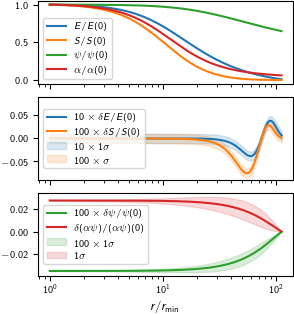

In [42]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(3, 3.2))

# ax[0].set_title('TOV solution and perturbation')

ax[0].plot(R/R[0], E/E[0], label=r"$E/E(0)$")
ax[0].plot(R/R[0], S/S[0], label=r"$S/S(0)$")
ax[0].plot(R/R[0], psi/psi[0], label=r"$\psi/\psi(0)$")
ax[0].plot(R/R[0], alpha/alpha[0], label=r"$\alpha/\alpha(0)$")
ax[0].set_xscale('log')
# ax[1].set_yscale('log')

ax[1].plot(R/R[0], 10* (E_perturbed - E)/E[0], label=r"$10 \times \delta E/E(0)$")
ax[1].plot(R/R[0], 100*(S_perturbed - S)/S[0], label=r"$100 \times \delta S/S(0)$")

ax[1].fill_between(R/R[0], 10* (E_perturbed - E)/E[0] - 0.01, 10* (E_perturbed - E)/E[0] +0.01, color='tab:blue', label=r"$10 \times 1 \sigma$", alpha=0.17)
ax[1].fill_between(R/R[0], 100*(S_perturbed - S)/S[0] - 0.01, 100*(S_perturbed - S)/S[0] +0.01, color='tab:orange', label=r"$100 \times \sigma$", alpha=0.17)


ax[2].plot(R/R[0], 100*(dpsi_solution(R)/R)/(psi[0]), c='tab:green', label=r"$100 \times \delta \psi/\psi(0)$")
ax[2].plot(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), c='tab:red', label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")

ax[2].fill_between(R/R[0], 100*(dpsi_solution(R)/R - np.sqrt(dpsi_var))/(psi[0]), 100*(dpsi_solution(R)/R + np.sqrt(dpsi_var))/(psi[0]), color='tab:green', label=r"$100 \times 1 \sigma$", alpha=0.17)
ax[2].fill_between(R/R[0], (d_alpha_psi_solution(R)/R - np.sqrt(dalpha_psi_var))/(alpha[0]*psi[0]), (d_alpha_psi_solution(R)/R + np.sqrt(dalpha_psi_var))/(alpha[0]*psi[0]), color='tab:red', label=r"$1 \sigma$", alpha=0.17)
# ax[2].fill_between(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")
g


ax[1].set_ylim((-0.09, 0.09))
# ax[1].set_xlim((0, np.max(R/R[0])))

ax[0].legend(loc='lower left')
ax[1].legend(loc='center left')
ax[2].set_xlabel(r"$r/r_{\min}$")

ax[2].legend(loc='center left')

plt.savefig("plots/tov.pdf")

In [1]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(3, 3.2))

# ax[0].set_title('TOV solution and perturbation')

ax[0].plot(R/R[0], E/E[0], label=r"$E/E(0)$")
ax[0].plot(R/R[0], S/S[0], label=r"$S/S(0)$")
ax[0].plot(R/R[0], psi/psi[0], label=r"$\psi/\psi(0)$")
ax[0].plot(R/R[0], alpha/alpha[0], label=r"$\alpha/\alpha(0)$")
ax[0].set_xscale('log')
# ax[1].set_yscale('log')

ax[1].plot(R/R[0],    (E_perturbed - E)/E[0], label=r"$\delta E/E(0)$")
ax[1].plot(R/R[0], 10*(S_perturbed - S)/S[0], label=r"$10 \times \delta S/S(0)$")

ax[1].fill_between(R/R[0],    (E_perturbed - E)/E[0] - 0.001,    (E_perturbed - E)/E[0] +0.001, color='tab:blue', label=r"$1 \sigma$", alpha=0.17)
ax[1].fill_between(R/R[0], 10*(S_perturbed - S)/S[0] - 0.001, 10*(S_perturbed - S)/S[0] +0.001, color='tab:orange', label=r"$10 \times \sigma$", alpha=0.17)


ax[2].plot(R/R[0], 100*(dpsi_solution(R)/R)/(psi[0]), c='tab:green', label=r"$100 \times \delta \psi/\psi(0)$")
ax[2].plot(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), c='tab:red', label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")

ax[2].fill_between(R/R[0], 100*(dpsi_solution(R)/R - np.sqrt(dpsi_var))/(psi[0]), 100*(dpsi_solution(R)/R + np.sqrt(dpsi_var))/(psi[0]), label=r"$100 \times 1 \sigma$ interval", alpha=0.17)
ax[2].fill_between(R/R[0], (d_alpha_psi_solution(R)/R - np.sqrt(dalpha_psi_var))/(alpha[0]*psi[0]), (d_alpha_psi_solution(R)/R + np.sqrt(dalpha_psi_var))/(alpha[0]*psi[0]), label=r"$1 \sigma$ interval", alpha=0.17)
# ax[2].fill_between(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")
g


ax[1].set_ylim((-0.09, 0.09))
# ax[1].set_xlim((0, np.max(R/R[0])))

ax[0].legend(loc='lower left')
ax[1].legend(loc='center left')
ax[2].set_xlabel(r"$r/r_{\min}$")

ax[2].legend(loc='center left')

plt.savefig("plots/tov.pdf")

NameError: name 'plt' is not defined

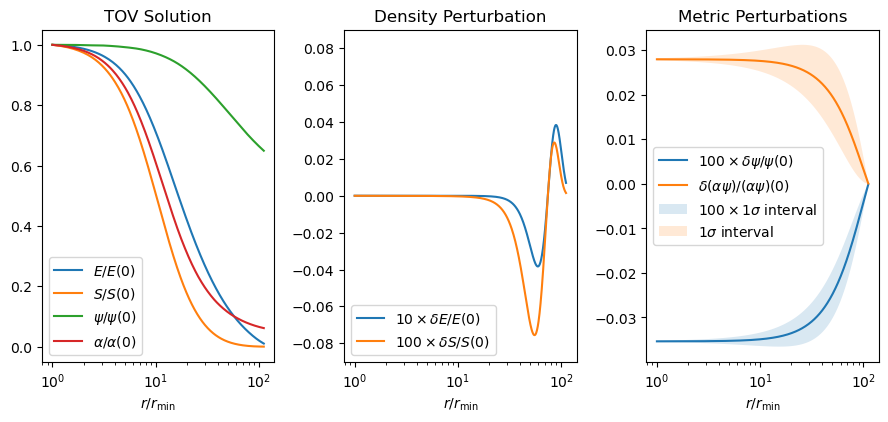

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True)

# fig.suptitle("Perturbation of a Neutron Star", fontsize=16)  # Use suptitle instead of title

# ax[0].set_title('TOV solution and perturbation')

dsF = 1000  #downsample factor

ax[0].plot(R[::dsF]/R[0], E[::dsF]/E[0], label=r"$E/E(0)$")
ax[0].plot(R[::dsF]/R[0], S[::dsF]/S[0], label=r"$S/S(0)$")
ax[0].plot(R[::dsF]/R[0], psi[::dsF]/psi[0], label=r"$\psi/\psi(0)$")
ax[0].plot(R[::dsF]/R[0], alpha[::dsF]/alpha[0], label=r"$\alpha/\alpha(0)$")
ax[0].set_xscale('log')
ax[0].set_xlabel(r"$r/r_{\min}$")
ax[0].set_title('TOV Solution')
# ax[1].set_yscale('log')

ax[1].plot(R[::dsF]/R[0], 10* (E_perturbed[::dsF] - E[::dsF])/E[0], label=r"$10 \times \delta E/E(0)$")
ax[1].plot(R[::dsF]/R[0], 100*(S_perturbed[::dsF] - S[::dsF])/S[0], label=r"$100 \times \delta S/S(0)$")
ax[1].set_xlabel(r"$r/r_{\min}$")
ax[1].set_title('Density Perturbation')

ax[2].plot(R[::dsF]/R[0], 100*(dpsi_solution(R[::dsF])/R[::dsF])/(psi[0]), label=r"$100 \times \delta \psi/\psi(0)$")
ax[2].plot(R[::dsF]/R[0], (d_alpha_psi_solution(R[::dsF])/R[::dsF])/(alpha[0]*psi[0]), label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")

ax[2].fill_between(R[::dsF]/R[0], 100*(dpsi_solution(R[::dsF])/R[::dsF] - np.sqrt(dpsi_var[::dsF]))/(psi[0]), 100*(dpsi_solution(R[::dsF])/R[::dsF] + np.sqrt(dpsi_var[::dsF]))/(psi[0]), label=r"$100 \times 1 \sigma$ interval", alpha=0.17)
ax[2].fill_between(R[::dsF]/R[0], (d_alpha_psi_solution(R[::dsF])/R[::dsF] - np.sqrt(dalpha_psi_var[::dsF]))/(alpha[0]*psi[0]), (d_alpha_psi_solution(R[::dsF])/R[::dsF] + np.sqrt(dalpha_psi_var[::dsF]))/(alpha[0]*psi[0]), label=r"$1 \sigma$ interval", alpha=0.17)
ax[2].set_title('Metric Perturbations')
# ax[2].fill_between(R/R[0], (d_alpha_psi_solution(R)/R)/(alpha[0]*psi[0]), label=r"$\delta (\alpha \psi)/(\alpha \psi)(0)$")



ax[1].set_ylim((-0.09, 0.09))


ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[2].set_xlabel(r"$r/r_{\min}$")

ax[2].legend(loc='center left')

plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.12, wspace=0.3)  # Adjust margins and spacing
plt.savefig("plots/tov_poster.png", bbox_inches='tight', pad_inches=0.02)  # Tight layout with minimal padding



plt.savefig("plots/tov_poster.svg")